In [169]:
HOME_DIR = "/home_remote"
HOME = "/home/thi.tra.my.nguyen"

from liwc import Liwc
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import word_tokenize, ngrams
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
#import logisitic_regression
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [469]:
pd.options.mode.chained_assignment = None

### Data preparation

In [238]:
positives_df_path = os.path.join(HOME_DIR, "positive_df.pkl")
negatives_df_path = os.path.join(HOME_DIR, "negative_df.pkl")

positives = pd.read_pickle(positives_df_path)
negatives = pd.read_pickle(negatives_df_path)

In [2]:
def construct_liwc_input(df, label):
  """
  params: df - The positive/negative dataframe loaded from pickle
    The df is expected to has these columns "Title", "Date", "Text", "SubjectId"
  params: label - The label need to be assigned to result dataframe

  returns: A dataframe contains "SubjectId", "AverageLength", "Text", "NumOfWritings", "Title"
  """
  subject_id_list = df.loc[:, "TrainSubjectId"].unique()

  df['text'] = df['Text']+ df['Title']
  
  df["Token"] = df["text"].apply(lambda x: word_tokenize(x))
  grouped_by_subject_id = df.groupby('TrainSubjectId')

  # calculate average token length for each user
  average_length_df = grouped_by_subject_id['Token'].apply(lambda token_series: sum(len(token) for token in token_series) / len(token_series)).reset_index()
  average_length_df.rename(columns={'Token': 'AverageLength'}, inplace=True)
  #print(average_length_df.head())

  # join all writings of single user into single corpus
  joined_text_df = grouped_by_subject_id['text'].apply(' '.join).reset_index()

  # calculate number of writings for each user
  number_of_writings_df = grouped_by_subject_id['Text'].apply(lambda x: len(x)).reset_index()
  number_of_writings_df.rename(columns={'Text': 'NumOfWritings'}, inplace=True)

  result_df = average_length_df.merge(joined_text_df, on="TrainSubjectId")
  result_df = result_df.merge(number_of_writings_df, on="TrainSubjectId")
  result_df["Label"] = label

  return result_df

In [5]:
input_positives = construct_liwc_input(positives, 1)
input_negatives = construct_liwc_input(negatives, 0)

In [6]:
liwc_input = pd.concat([input_positives, input_negatives])
liwc_input = liwc_input.sample(frac=1).reset_index(drop=True)

In [228]:
data_input = liwc_input[['TrainSubjectId', 'Label', 'text']]

### Hand-crafted features

In [221]:
pip install textstat

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.7 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [225]:
import textstat

In [293]:
#positives['text'] = positives['Text']+ positives['Title']
  
positives["Token"] = positives["Text"].apply(lambda x: word_tokenize(x))
positives["LWF"] = positives['Text'].apply(lambda x: textstat.linsear_write_formula(x))
positives["FRE"] = positives['Text'].apply(lambda x: textstat.flesch_reading_ease(x))
positives["DCR"] = positives['Text'].apply(lambda x: textstat.dale_chall_readability_score(x))
positives["FOG"] = positives['Text'].apply(lambda x: textstat.gunning_fog(x))
#positives["ARI"] = positives['text'].apply(lambda x: textstat.automated_readability_index(x))
#positives["SMOG"] = positives['text'].apply(lambda x: textstat.smog_index(x))
positives["AVG_SEN"] = positives['Text'].apply(lambda x:  textstat.avg_sentence_length(x))
positives["AVG_PER_WORD"] = positives['Text'].apply(lambda x:  textstat.avg_letter_per_word(x))

In [294]:
#negatives['text'] = negatives['Text']+ negatives['Title']
negatives["Token"] = negatives["Text"].apply(lambda x: word_tokenize(x))
negatives["LWF"] = negatives['Text'].apply(lambda x: textstat.linsear_write_formula(x))
negatives["FRE"] = negatives['Text'].apply(lambda x: textstat.flesch_reading_ease(x))
negatives["DCR"] = negatives['Text'].apply(lambda x: textstat.dale_chall_readability_score(x))
negatives["FOG"] = negatives['Text'].apply(lambda x: textstat.gunning_fog(x))
negatives["AVG_SEN"] = negatives['Text'].apply(lambda x:  textstat.avg_sentence_length(x))
negatives["AVG_PER_WORD"] = negatives['Text'].apply(lambda x:  textstat.avg_letter_per_word(x))


In [295]:
positives_mean = positives.groupby('TrainSubjectId').agg({'LWF': 'mean', 'FRE': 'mean', 'DCR': 'mean', 'FOG': 'mean','AVG_SEN':'mean', 'AVG_PER_WORD': 'mean'}).reset_index()
negatives_mean = negatives.groupby('TrainSubjectId').agg({'LWF': 'mean', 'FRE': 'mean', 'DCR': 'mean', 'FOG': 'mean','AVG_SEN':'mean', 'AVG_PER_WORD':'mean'}).reset_index()
positives_mean['Label'] = 1
negatives_mean['Label'] = 0
#concat
handcrafted = pd.concat([positives_mean, negatives_mean])

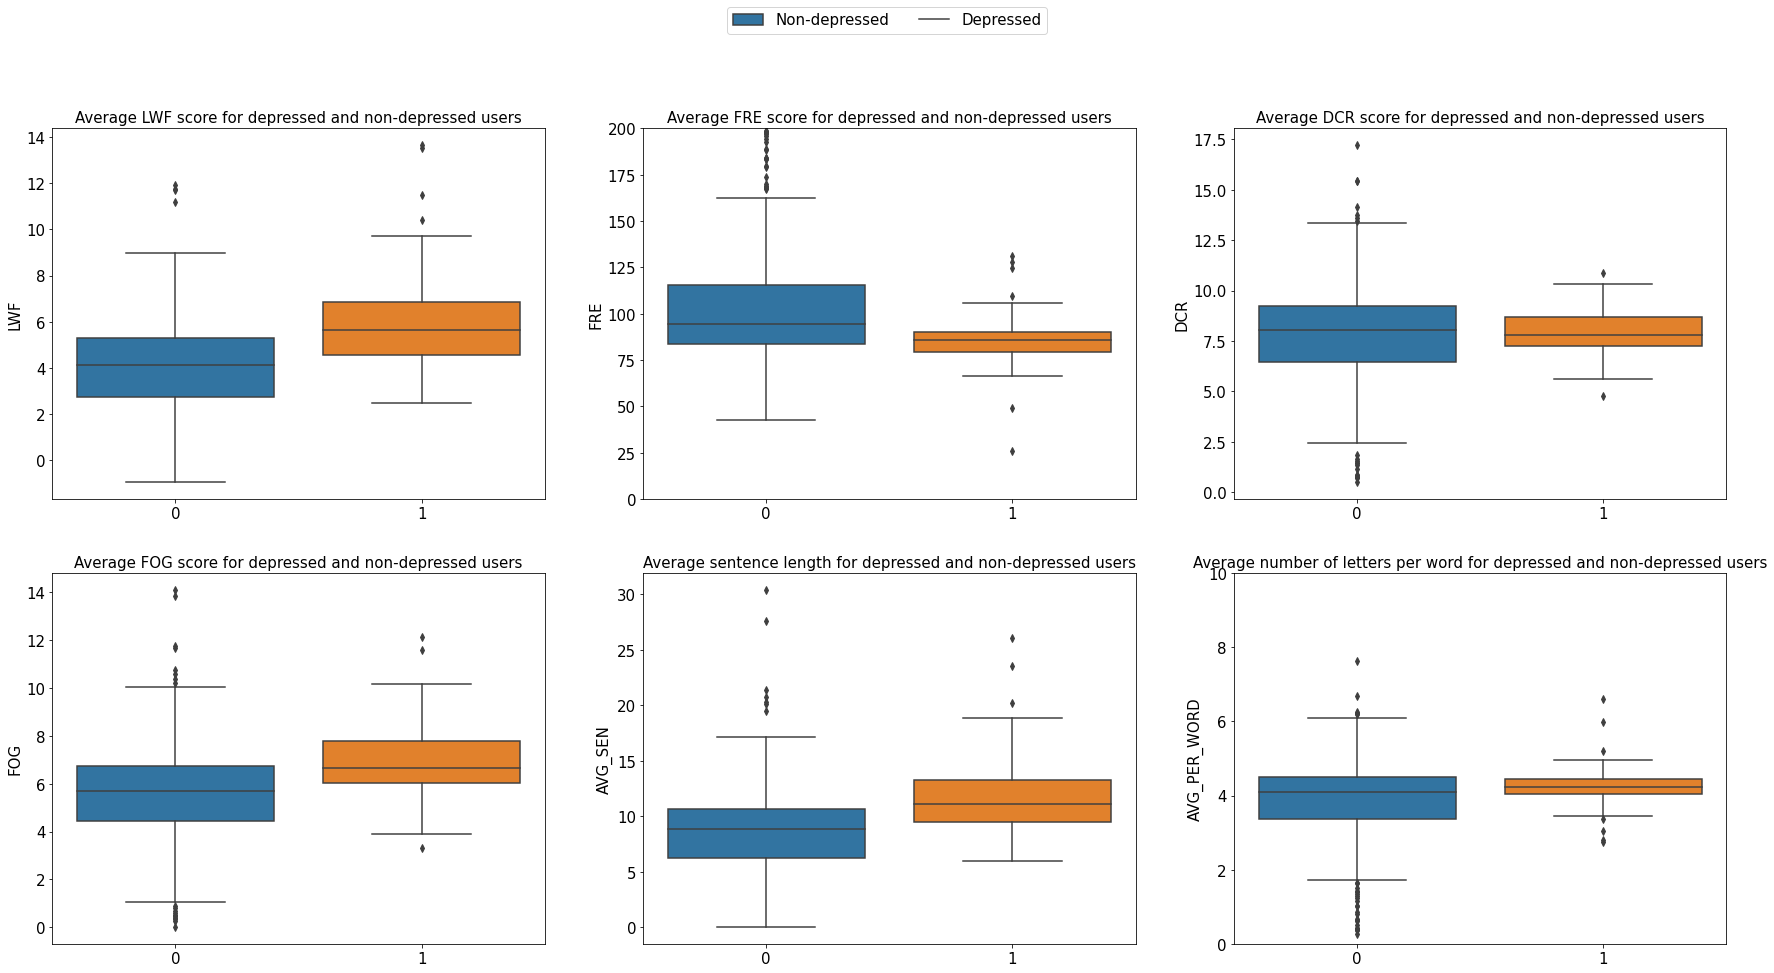

In [325]:
#boxplot for each feature in positives_mean and negatives_mean in the same figure
fig = plt.figure(figsize=(30,15))
plt.subplot(2,3,1)
sns.boxplot(x='Label', y='LWF', data=handcrafted)
plt.title('Average LWF score for depressed and non-depressed users', fontsize=15)
#set label for x is none
plt.xlabel(None)
#change size of y label
plt.ylabel('LWF', fontsize=15)
#change size of x axis
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.subplot(2,3,2)
#change limit of y axis
plt.ylim(0, 200)
sns.boxplot(x='Label', y='FRE', data=handcrafted)
plt.title('Average FRE score for depressed and non-depressed users', fontsize=15)
#set label for x is none
plt.xlabel(None)
#change size of y label
plt.ylabel('FRE', fontsize=15)
#change size of x axis
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#change values of x axis 1: depressed, 0: non-depressed

plt.subplot(2,3,3)
sns.boxplot(x='Label', y='DCR', data=handcrafted)
plt.title('Average DCR score for depressed and non-depressed users', fontsize=15)
#set label for x is none
plt.xlabel(None)
#change size of y label
plt.ylabel('DCR', fontsize=15)
#change size of x axis
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.subplot(2,3,4)
sns.boxplot(x='Label', y='FOG', data=handcrafted)
plt.title('Average FOG score for depressed and non-depressed users', fontsize=15)
#set label for x is none
plt.xlabel(None)
#change size of y label
plt.ylabel('FOG', fontsize=15)
#change size of x axis
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.subplot(2,3,5)
sns.boxplot(x='Label', y='AVG_SEN', data=handcrafted)
plt.title('Average sentence length for depressed and non-depressed users', fontsize=15)

#set label for x is none
plt.xlabel(None)
#change size of y label
plt.ylabel('AVG_SEN', fontsize=15)
#change size of x axis
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.subplot(2,3,6)
#change limit of y axis
plt.ylim(0, 10)
sns.boxplot(x='Label', y='AVG_PER_WORD', data=handcrafted)
plt.title('Average number of letters per word for depressed and non-depressed users', fontsize=15)
#set label for x is none
plt.xlabel(None)
#change size of y label
plt.ylabel('AVG_PER_WORD', fontsize=15)
#change size of x axis
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#legend for the whole figure. 2 columns, 1 row
fig.legend(labels=['Non-depressed', 'Depressed'], loc='upper center', ncol=2, fontsize=15)

#save figure
plt.savefig(os.path.join(HOME_DIR, "handcrafted_features.pdf"), bbox_inches='tight')

### test on other features

In [396]:
#bi-gram features for data input
def get_ngrams(text, n):
  n_grams = ngrams(word_tokenize(text), n)
  return [ ' '.join(grams) for grams in n_grams]
bigram =[ get_ngrams(i, 2) for i in data_input['text']]

In [398]:
#count frequency of phase 'my depression' in each user
my_depression = []
for i in bigram:
  count = 0
  for j in i:
    if j == 'my depression':
      count += 1
  my_depression.append(count)

In [403]:
#count frequency of phase 'my anxiety' in each user
my_anxiety = []
for i in bigram:
  count = 0
  for j in i:
    if j == 'my anxiety':
      count += 1
  my_anxiety.append(count)

In [542]:
X_alike_handcrafted['Depression'] = my_depression
X_alike_handcrafted['My Anxiety'] = my_anxiety

In [543]:
X_handcrafted['Depression'] = my_depression
X_handcrafted['My Anxiety'] = my_anxiety

In [461]:
#unigram
unigram =[ get_ngrams(i, 1) for i in data_input['text']]
#count frequency of word 'I' in each user
count_i = []
for i in unigram:
  count = 0
  for j in i:
    if j == 'I':
      count += 1
  count_i.append(count)

In [535]:
X_alike_handcrafted['word_I'] = count_i
X_handcrafted['word_I'] = count_i

### Including hand-crafted features

In [561]:

def construct_liwc_input_crafted(df, label):
  """
  params: df - The positive/negative dataframe loaded from pickle
    The df is expected to has these columns "Title", "Date", "Text", "SubjectId"
  params: label - The label need to be assigned to result dataframe

  returns: A dataframe contains "SubjectId", "AverageLength", "Text", "NumOfWritings", "Title"
  """
  subject_id_list = df.loc[:, "TrainSubjectId"].unique()

  df['text'] = df['Text']+ df['Title']
  df['Token'] = df['text'].apply(lambda x: word_tokenize(x))
  df['AVG_SEN'] = df['text'].apply(lambda x:  textstat.avg_sentence_length(x))
  df['AVG_PER_WORD'] = df['text'].apply(lambda x:  textstat.avg_letter_per_word(x))
  df['LWF'] = df['text'].apply(lambda x: textstat.linsear_write_formula(x))
  df['FRE'] = df['text'].apply(lambda x: textstat.flesch_reading_ease(x))
  df['DCR'] = df['text'].apply(lambda x: textstat.dale_chall_readability_score(x))
  df['FOG'] = df['text'].apply(lambda x: textstat.gunning_fog(x))
  
  result_df = df.groupby('TrainSubjectId').agg({'LWF': 'mean', 'FRE': 'mean', 'DCR': 'mean', 'FOG': 'mean','AVG_SEN':'mean', 'AVG_PER_WORD': 'mean', 'Text':'count'}).reset_index()
  result_df["Label"] = label
 
  #join text per user
  joined_text_df = df.groupby('TrainSubjectId')['text'].apply(' '.join).reset_index()
  result_df = result_df.merge(joined_text_df, on="TrainSubjectId")

  # number_of_writings_df = df.groupby('TrainSubjectId')['Text'].apply(lambda x: len(x)).reset_index()
  result_df.rename(columns={'Text': 'NumOfWritings'}, inplace=True)

  # #merge number of writings and result_df on trainSubjectId
  # result_df_final = result_df.merge(number_of_writings_df, on="TrainSubjectId")
  
  return result_df

In [562]:
p = construct_liwc_input_crafted(positives, 1)

In [563]:
p

,TrainSubjectId,LWF,FRE,DCR,FOG,AVG_SEN,AVG_PER_WORD,NumOfWritings,Label,text
0,train_subject1095,5.605148,81.937775,8.743571,6.619235,11.231310,4.257142,1137,1,The last line is pretty much the same as the ...
1,train_subject1190,6.429298,81.244512,8.249394,7.039798,12.715152,4.365589,297,1,"I'm sure I'll get flamed for this, but true f..."
2,train_subject1191,5.661012,85.571250,6.960000,6.644375,11.118750,4.029375,16,1,Hi Ruben! Happy Birthday! I can't seem ...
3,train_subject1199,5.970310,44.049545,10.784286,8.234870,11.487662,6.780455,154,1,"In the US, the Supreme Court has ruled that i..."
4,train_subject1201,3.687641,82.959531,8.922881,5.444824,8.190787,4.620134,597,1,lol I do that on a regular basis. ;) how...
...,...,...,...,...,...,...,...,...,...,...
78,train_subject9552,9.733333,68.410000,8.462963,9.752222,15.677778,4.591111,27,1,SpaceX. A company like that doesn't worry abo...
79,train_subject96,13.515000,72.994000,7.932000,12.128000,23.510000,4.144000,10,1,"I'm pretty sure the definition is ""It's not s..."
80,train_subject9683,6.177137,74.713783,11.440411,7.201026,12.087097,4.928094,341,1,"Cavs trade 3 non-guaranteed deals, Dwight P..."
81,train_subject9763,8.085502,83.437958,7.442465,7.967817,16.623944,4.056761,142,1,What's your best natural beauty \n\nThat amaz...


In [330]:
positives_crafted= construct_liwc_input_crafted(positives, 1)
negatives_crafted = construct_liwc_input_crafted(negatives, 0)
#concat
df_handcrafted = pd.concat([positives_crafted, negatives_crafted])
df_handcrafted = df_handcrafted.sample(frac=1).reset_index(drop=True)

In [332]:
df_handcrafted.to_pickle(os.path.join(HOME_DIR, "df_handcrafted.pkl"))

### Feature Extraction

In [8]:
# Load LIWC dictionary
liwc = Liwc(os.path.join(HOME_DIR, "master_thesis/LIWC2007_English100131.dic"))
input = [liwc.parse(word_tokenize(text)) for text in data_input['text']]

In [9]:
# Load LIWC-alike dictionary
%run /home_remote/master_thesis/model_evaluation/liwc_alike.py
liwc_alike_output = [main(text, result) for text in data_input['text']]

In [553]:
#extract features and handcrafted features
def get_features_crafted(df,output, type):
    hand_crafted = ['LWF', 'FOG', 'FRE', 'DCR', 'AVG_SEN', 'AVG_PER_WORD']
    relevant_features_name ={'liwc': ['i', 'friend', 'sad', 'family', 'feel', 'health',
       'sexual', 'anx', 'body', 'bio', 'ppron', 'filler', 'shehe', 'adverb',
       'swear', 'humans', 'excl', 'assent', 'discrep', 'you', 'pronoun',
       'negemo', 'past'],
                        'liwc_alike': ['Anxiety', 'I', 'Sadness', 'Affective Processes',
       'Sexuality', 'Family', 'Friends', 'Fillers', 'Health', 'Feeling',
       'Humans', 'Biological Processes', 'Time', 'Body', 'Negative Emotions',
       'Social Processes', 'Perceptual Processes', 'Insight',
       'Cognitive Processes', 'Motion', 'Positive Emotions', 'Tentative',
       'Ppronouns']}
    vector_df = pd.DataFrame(output, index=df.index)
    #vector_df_norm = vector_df.div(vector_df.sum(axis=1), axis=0)
    #vector_df_norm['Label'] = df['Label']
    #vector_df_norm['TrainSubjectId'] = df['TrainSubjectId']
    vector_df= vector_df.fillna(0)
    #corr = vector_df_norm.corr()
    #corr_label = corr['Label'].sort_values(ascending=False)
    #relevant_features = corr_label[1:15]
    #relevant_features_name = relevant_features.index.values
    re = vector_df[relevant_features_name[type]]
    for i in hand_crafted:
        re[i] = df[i]
    X = re
    y = df['Label']
    return X, y

In [533]:
X_handcrafted, y_handcrafted = get_features_crafted(df_handcrafted, input, 'liwc')

In [534]:
X_alike_handcrafted, y_alike_handcrafted = get_features_crafted(df_handcrafted, liwc_alike_output, 'liwc_alike')

In [342]:
#extract top 15 features based on percentage. 
def get_features_top15(df, output):
    #df['vector'] = output
    vector_df = pd.DataFrame(output, index=df.index)
    vector_df_norm = vector_df.div(vector_df.sum(axis=1), axis=0)
    vector_df_norm['Label'] = df['Label']
    vector_df_norm['TrainSubjectId'] = df['TrainSubjectId']
    vector_df_norm = vector_df_norm.fillna(0)
    corr = vector_df_norm.corr()
    corr_label = corr['Label'].sort_values(ascending=False)
    relevant_features = corr_label[1:40]
    relevant_features_name = relevant_features.index.values
    X = vector_df_norm[relevant_features_name]
    y = vector_df_norm['Label']
    return X, y

In [161]:
X_liwc_alike_15, y_liwc_alike_15 = get_features_top15(data_input, liwc_alike_output)

In [206]:
#using chi2 to extract top 15 features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
def get_features_chi2(df, output):
    vector_df = pd.DataFrame(output, index=df.index)
    vector_df_norm = vector_df.div(vector_df.sum(axis=1), axis=0)
    vector_df_norm['Label'] = df['Label']
    vector_df_norm['TrainSubjectId'] = df['TrainSubjectId']
    vector_df_norm = vector_df_norm.fillna(0)
    X = vector_df_norm.drop(['Label', 'TrainSubjectId'], axis=1)
    y = vector_df_norm['Label']
    X_new = SelectKBest(chi2, k=4).fit_transform(X, y)
    return X_new, y

In [218]:
#extraction using mutual information
from sklearn.feature_selection import mutual_info_classif
def get_features_mutual_info(df, output):
    vector_df = pd.DataFrame(output, index=df.index)
    vector_df_norm = vector_df.div(vector_df.sum(axis=1), axis=0)
    vector_df_norm['Label'] = df['Label']
    vector_df_norm['TrainSubjectId'] = df['TrainSubjectId']
    vector_df_norm = vector_df_norm.fillna(0)
    X = vector_df_norm.drop(['Label', 'TrainSubjectId'], axis=1)
    y = vector_df_norm['Label']
    X_new = SelectKBest(mutual_info_classif, k=15).fit_transform(X, y)
    return X_new, y

In [207]:
X_alike_chi_15, y_alike_chi_15 = get_features_chi2(data_input, liwc_alike_output)

In [219]:
X_alike_mutual_15, y_alike_mutual_15 = get_features_mutual_info(data_input, liwc_alike_output)

### Models

In [366]:
def logistic_regression(X, y):

    w = [1, 2**1, 2**2, 2**3, 2**4, 2**5, 2**6,2**7, 2**8]
    weight = [{0: 1/(1+x),  1: x/(1+x)} for x in w]
    C = [2**-6, 2**-5, 2**-4, 2**-3, 2**-2, 2**-1, 1, 2**1, 2**2, 2**3, 2**4, 2**5, 2**6]
    # define grid search
    hyperparam_grid = {"class_weight": weight
                    ,"C": C
                    ,"penalty": ["l1", "l2"]
                    ,"fit_intercept": [True, False]  }
    # define evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=13)
    # define grid search
    model_test = LogisticRegression()
    grid = GridSearchCV(estimator=model_test, param_grid=hyperparam_grid, cv=cv, scoring='f1')
    grid_result = grid.fit(X, y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    #build a model with the best parameters, fix class_weight = (0.2, 0.8)

    model = LogisticRegression(**grid_result.best_params_)
    model.fit(X, y)
    return model

### PCA

In [442]:
a = pd.DataFrame(liwc_alike_output, index=data_input.index)
b = a.div(a.sum(axis=1), axis=0)
b = b.fillna(0)

In [451]:
lc_pca = pd.DataFrame(input, index=data_input.index)
liwc_pca = lc_pca.div(lc_pca.sum(axis=1), axis=0)
liwc_pca = liwc_pca.fillna(0)
X_liwc_pca = PCA(n_components=15).fit_transform(liwc_pca)

In [443]:
#save pca model
pca = PCA(n_components=15)
pca.fit(b)
c = pca.transform(b)
#joblib.dump(pca, os.path.join(HOME_DIR,'pca.pkl'))

In [447]:
model_pca = LogisticRegression(C = 64, class_weight = {0: 0.2, 1: 0.8}, fit_intercept = True, penalty = 'l1', solver='liblinear')
model_pca.fit(c, data_input['Label'])
y_pred_pca = model_pca.predict(c)
print(classification_report(data_input['Label'], y_pred_pca))
print(f1_score(data_input['Label'], y_pred_pca))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       403
           1       0.54      0.82      0.65        83

    accuracy                           0.85       486
   macro avg       0.75      0.84      0.78       486
weighted avg       0.89      0.85      0.86       486

0.6476190476190478


In [452]:
model_pca_liwc = LogisticRegression(C = 64, class_weight = {0: 0.2, 1: 0.8}, fit_intercept = True, penalty = 'l1', solver='liblinear')
model_pca_liwc.fit(liwc_pca, data_input['Label'])
y_pred_pca_liwc = model_pca_liwc.predict(liwc_pca)
print(classification_report(data_input['Label'], y_pred_pca_liwc))
print(f1_score(data_input['Label'], y_pred_pca_liwc))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       403
           1       0.50      0.76      0.60        83

    accuracy                           0.83       486
   macro avg       0.72      0.80      0.74       486
weighted avg       0.87      0.83      0.84       486

0.6


In [453]:
joblib.dump(model_pca_liwc, os.path.join(HOME_DIR,'model_pca_liwc.pkl'))

['/home_remote/model_pca_liwc.pkl']

In [449]:
joblib.dump(model_pca, os.path.join(HOME_DIR,'model_pca_liwc_alike.pkl'))

['/home_remote/model_pca_liwc_alike.pkl']

#### Test PCA and hand-crafted


In [548]:
#dataframe c
c_df = pd.DataFrame(c)
c_df['I'] = count_i
c_df['Depression'] = my_depression
c_df['My Anxiety'] = my_anxiety

### Test with LR

In [159]:
model = logistic_regression(X_liwc_alike_15, y_liwc_alike_15)
y_pred_15 = model.predict(X_liwc_alike_15)
print(classification_report(y_liwc_alike_15, y_pred_15))

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best: 0.621761 using {'C': 64, 'class_weight': {0: 0.3333333333333333, 1: 0.6666666666666666}, 'fit_intercept': True}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       403
           1       0.65      0.13      0.22        83

    accuracy                           0.84       486
   macro avg       0.75      0.56      0.57       486
weighted avg       0.81      0.84      0.79       486



In [208]:
#test with X_alike_chi_15
model_chi = logistic_regression(X_alike_chi_15, y_alike_chi_15)
y_pred_15_chi = model_chi.predict(X_alike_chi_15)
print(classification_report(y_pred_15_chi, y_alike_chi_15))

Best: 0.585963 using {'C': 64, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': True}
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       380
           1       0.60      0.47      0.53       106

    accuracy                           0.82       486
   macro avg       0.73      0.69      0.71       486
weighted avg       0.80      0.82      0.81       486



In [220]:
#test with X_alike_mutual_15
model_mutual = logistic_regression(X_alike_mutual_15, y_alike_mutual_15)
y_pred_15_mutual = model_mutual.predict(X_alike_mutual_15)
print(classification_report(y_pred_15_mutual, y_alike_mutual_15))

Best: 0.605273 using {'C': 16, 'class_weight': {0: 0.2, 1: 0.8}, 'fit_intercept': False}
              precision    recall  f1-score   support

           0       1.00      0.83      0.91       482
           1       0.04      0.75      0.07         4

    accuracy                           0.83       486
   macro avg       0.52      0.79      0.49       486
weighted avg       0.99      0.83      0.90       486



In [564]:
md = LogisticRegression(C = 4, class_weight = {0: 0.2, 1: 0.8}, penalty = 'l1', solver='liblinear')
md.fit(X_handcrafted, y_handcrafted)
y_handcrafted_pred = md.predict(X_handcrafted)
#print f1 score
print('F1 score: ', f1_score(y_handcrafted, y_handcrafted_pred))

F1 score:  0.5462184873949579


In [551]:
md = LogisticRegression(C = 4, class_weight = {0: 0.2, 1: 0.8}, penalty = 'l1', solver='liblinear', fit_intercept = True)
md.fit(X_alike_handcrafted, y_alike_handcrafted)
y_alike_handcrafted_pred = md.predict(X_alike_handcrafted)
#print f1 score
print('F1 score: ', f1_score(y_alike_handcrafted, y_alike_handcrafted_pred))

F1 score:  0.5569620253164557


In [550]:
X_alike_handcrafted

,Anxiety,I,Sadness,Affective Processes,Sexuality,Family,Friends,Fillers,Health,Feeling,...,Ppronouns,LWF,FOG,FRE,DCR,AVG_SEN,AVG_PER_WORD,word_I,Depression,My Anxiety
0,5.0,94.0,2.0,11.0,7.0,16.0,18.0,0.0,41.0,49.0,...,296,5.605148,6.619235,81.937775,8.743571,11.231310,4.257142,221,1,0
1,19.0,239.0,23.0,119.0,65.0,56.0,107.0,0.0,37.0,461.0,...,2016,4.998421,8.600466,54.511370,14.550714,9.582653,5.979548,931,0,0
2,22.0,192.0,37.0,115.0,48.0,287.0,150.0,0.0,253.0,404.0,...,3761,7.510654,8.776853,72.480019,9.191313,14.441892,4.692336,668,0,0
3,10.0,134.0,16.0,30.0,17.0,38.0,55.0,0.0,10.0,103.0,...,729,6.428792,9.168175,53.461234,13.604531,11.577520,5.876640,320,0,0
4,31.0,269.0,13.0,39.0,65.0,43.0,54.0,0.0,66.0,183.0,...,1081,5.814043,7.193333,84.571111,8.456111,12.105556,4.118333,434,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,16.0,89.0,13.0,45.0,16.0,56.0,19.0,1.0,121.0,150.0,...,1208,3.066783,5.148698,74.019023,12.005814,7.109767,5.513581,315,0,0
482,4.0,37.0,2.0,5.0,3.0,10.0,13.0,0.0,1.0,28.0,...,238,5.645811,6.621579,80.769123,9.403333,11.316667,4.336491,93,0,0
483,41.0,168.0,34.0,99.0,30.0,62.0,57.0,0.0,132.0,389.0,...,2892,6.070336,7.458582,76.143247,8.379630,11.934200,4.574925,567,0,0
484,67.0,371.0,27.0,121.0,45.0,44.0,49.0,2.0,571.0,513.0,...,5405,4.759871,8.318931,62.149830,12.878742,9.236897,5.426982,1265,0,1


In [565]:
joblib.dump(md, os.path.join(HOME_DIR,'handcrafted_liwc23.pkl'))

['/home_remote/handcrafted_liwc23.pkl']

### LSTM

In [99]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Example text data (replace this with your actual text data)
texts = data_input['text'].tolist()
# Create a tokenizer and fit it on your text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# Get the vocabulary size
vocabulary_size = len(tokenizer.word_index) + 1  # Add 1 for the special padding token if used

print("Vocabulary Size:", vocabulary_size)

Vocabulary Size: 165172


In [101]:
X_train, X_test, y_train, y_test = train_test_split(c, data_input['Label'], test_size=0.2, random_state=13)

In [108]:
#lstm 
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the model
model2 = Sequential()

# Embedding layer
model2.add(Embedding(input_dim = 15 , output_dim =128))

# LSTM layer with ReLU activation and dropout
model2.add(LSTM(128, activation='relu', dropout=0.3, recurrent_dropout=0.3))

# Fully connected layer with ReLU activation
model2.add(Dense(128, activation='relu', kernel_regularizer='l2', bias_regularizer='l2'))

# Dropout layer
model2.add(Dropout(0.3))

# Output layer with softmax activation for binary classification
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

# Learning rate decay scheduler
def lr_scheduler(epoch, lr):
    return lr * np.exp(-1e-5 * epoch)

lr_callback = LearningRateScheduler(lr_scheduler)

# Train the model
model2.fit(X_train, y_train, epochs=130, batch_size=100, callbacks=[lr_callback], class_weight={0: 0.2, 1: 0.8})

2023-11-13 23:44:56.661048: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.5KiB (rounded to 7680)requested by op RandomUniform
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-11-13 23:44:56.661127: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2023-11-13 23:44:56.661156: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 4, Chunks in use: 3. 1.0KiB allocated for chunks. 768B in use in bin. 16B client-requested in use in bin.
2023-11-13 23:44:56.661178: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-11-13 23:44:56.661199: I tensorflow/core/common_runt

ResourceExhaustedError: OOM when allocating tensor with shape[15,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]